In [1]:
#Restart kernel if rerunning this cell
import os 
wd = os.path.dirname(os.getcwd()).replace('\\', '/')
os.chdir(wd)

import pandas as pd
import geopandas as gpd
import scripts.preprocess_helper as ph
import scripts.cleanup_helper as ch
import scripts.overlay_map_helper as omh
import omegaconf
import warnings
import folium
import geopandas as gpd
from geocube.api.core import make_geocube
import tobler
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
tract_pop = gpd.read_parquet('data/population/tract_pop/tract_pop.geoparquet').to_crs('EPSG:3857')
coops = gpd.read_parquet('data/coops_utilities/rural_coops/rural_coops.geoparquet')
md_parquet = gpd.read_parquet('data/population/building_footprint/final_geoparquet/Maryland.geoparquet').to_crs('EPSG:3857')

<Axes: >

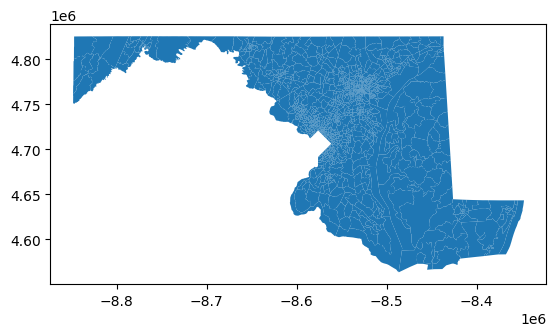

In [5]:
tract_pop[tract_pop['state']=='MD'].plot()

#### Small sample test

In [4]:
md_pop = tract_pop.query('state == "MD"').reset_index(drop = True)
md_coops = coops.query('State == "Maryland"').reset_index(drop = True)

In [116]:
intersected_geometries = gpd.overlay(md_coops, md_pop, how='intersection')

In [103]:
spatial_idx = md_parquet.sindex
bbox = intersected_geometries.bounds.iloc[100].to_list()
possible_matches_index = list(spatial_idx.intersection(bbox))

In [104]:
possible_matches = md_parquet.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(intersected_geometries.iloc[100].geometry)]

<Axes: >

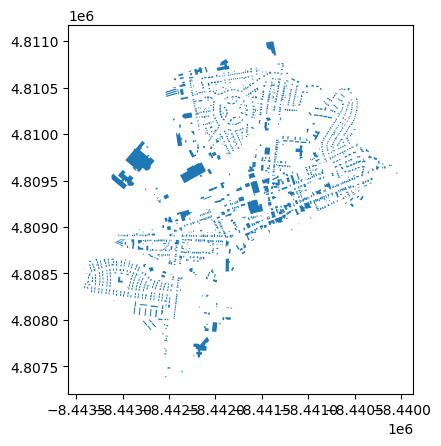

In [105]:
precise_matches.plot()

In [99]:
md_pop[md_pop['tract_id'] == 24015030400]

,state,tractName,tractId,total_pop,tract_id,lat,lon,geometry
35227,MD,"Census Tract 304, Cecil County, Maryland",24015030400,4807,24015030400,+39.6081745,-075.8372909,"POLYGON ((-8443803.121 4808496.379, -8443801.1..."


In [17]:
from shapely import Polygon

minx, miny, maxx, maxy = bbox
coords = ((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny))
bounds_polygon = Polygon(coords)

bbox_gdf = gpd.GeoDataFrame(data={"geometry": [bounds_polygon]}, crs="EPSG:3857")
bbox_gdf

,geometry
0,"POLYGON ((-8443803.789 4807001.537, -8443803.7..."


In [ ]:
m = folium.Map()
folium.GeoJson(intersected_geometries).add_to(m)
folium.GeoJson(precise_matches, style_function=lambda c: {"color": "green", "fillColor":"green"}).add_to(m)
folium.GeoJson(bbox_gdf, style_function=lambda c: {"color": "red"}).add_to(m)
m

#### Testing on whole state

In [39]:
md_pop2 = md_pop.copy()
spatial_idx = md_parquet.sindex

# Create a list to store the tract geometry and not lose it while making spatial operations
tract_geometry = []

# Loop through each tract
for i, tract_row in md_pop2.iterrows():
    tract_geo = tract_row.geometry
    bbox = tract_geo.bounds
    
    # Find precise matches (buildings) within the tract using spatial index
    possible_matches_index = list(spatial_idx.intersection(bbox))
    possible_matches = md_parquet.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(tract_geo)]
    precise_matches_polygon = MultiPolygon(precise_matches.geometry.values)
    
    # Store tract geometry
    tract_geometry.append((tract_row['tractName'], tract_row['geometry'], precise_matches_polygon))

# Create a DataFrame to hold tract geometries
tract_gdf = gpd.GeoDataFrame(tract_geometry, columns=['tractName', 'tract_geometry', 'precise_matches'])
tract_gdf.head(2)


,tractName,tract_geometry,precise_matches
0,"Census Tract 1, Allegany County, Maryland","POLYGON ((-8757112.830057712 4815084.60969388,...",MULTIPOLYGON (((-8737645.388827274 4796542.876...
1,"Census Tract 2, Allegany County, Maryland",POLYGON ((-8769554.452946221 4808258.853966532...,MULTIPOLYGON (((-8751171.820153564 4799163.013...


### Testing population estimation on one tract

In [43]:
md_pop2['geometry_buildings'] = gpd.GeoSeries(precise_matches_tract)
md_pop2['building_area'] = md_pop2['geometry_buildings'].area
md_pop2['tract_geometry'] = tract_geometry
test_tract = md_pop2.query('tractName == "Census Tract 8602, Calvert County, Maryland"')
test_coop = md_coops.query('NAME == "SOUTHERN MARYLAND ELEC COOP INC"')
test_overlay = gpd.overlay(test_tract.set_geometry('geometry_buildings'), test_coop, how = 'intersection')
test_overlay['intersected_area'] = test_overlay.geometry.area /test_overlay.building_area 
test_overlay['pop_intersect'] = test_overlay['intersected_area'] * test_overlay['total_pop']
test_overlay

,state,tractName,tractId,total_pop,tract_id,lat,lon,geometry,building_area,tract_geometry,ID,NAME,ADDRESS,CITY,ST_Code,ZIP,TELEPHONE,TYPE,COUNTRY,NAICS_CODE,NAICS_DESC,WEBSITE,REGULATED,CNTRL_AREA,PLAN_AREA,HOLDING_CO,SUMMR_PEAK,WINTR_PEAK,SUMMER_CAP,WINTER_CAP,NET_GEN,PURCHASED,NET_EX,RETAIL_MWH,WSALE_MWH,TOTAL_MWH,TRANS_MWH,CUSTOMERS,YEAR,Shape__Are,Shape__Len,State,area,Type_1,intersected_area,pop_intersect
0,MD,"Census Tract 8602, Calvert County, Maryland",24009860200,6022,24009860200,+38.6758822,-076.6579871,"MULTIPOLYGON (((-8526713.878 4675269.371, -852...",1.039559e+06,"(Census Tract 8602, Calvert County, Maryland, ...",17637,SOUTHERN MARYLAND ELEC COOP INC,NOT AVAILABLE,NOT AVAILABLE,MD,NOT AVAILABLE,NOT AVAILABLE,COOPERATIVE,USA,2211,"ELECTRIC POWER GENERATION, TRANSMISSION AND DI...",NOT AVAILABLE,REGULATED,"PJM INTERCONNECTION, LLC",NOT AVAILABLE,SOUTHERN MARYLAND ELEC COOP INC,803.0,725.0,-999999.0,-999999.0,-999999,2430188,901302,3241824,-999999,3331490,0,169339,2020,0.322201,6.118238,Maryland,5.098885e+09,Rural Co-Op,0.985485,5934.59122


### Estimating tract level population within coop territories on the entire state

In [44]:
# Loop through each coop
for coop_idx, coop_row in md_coops.iterrows():
    coop_geo = coop_row.geometry
    
    # Create a GeoDataFrame for the coop geometry
    coop_gdf = gpd.GeoDataFrame({'coop_geometry': [coop_geo]})
    
    # Overlay tract geometries and coop geometry
    overlay = gpd.overlay(
        tract_gdf.set_geometry('tract_geometry'),
        coop_gdf.set_geometry('coop_geometry'),
        how='intersection'
    )
    overlay = overlay.merge(tract_gdf[['tractName', 'tract_geometry']], on='tractName', how='left')
    overlay['tract_geometry'] = gpd.GeoSeries(overlay['tract_geometry'])
    
    # Merge md_pop2 to overlay to include total_pop
    overlay = overlay.merge(md_pop2[['tractName', 'total_pop']], on='tractName', how='left')
    
    # Calculate intersected area and population within the coop area for each tract
    overlay['intersected_area'] = overlay.geometry.area / overlay.tract_geometry.area
    overlay['pop_intersect'] = overlay['intersected_area'] * overlay['total_pop']
    
    # Sum up the population within the coop area for each tract and store in md_pop DataFrame
    for idx, row in overlay.iterrows():
        md_pop2.at[row['tractName'], f'pop_{coop_row["NAME"]}'] = row['pop_intersect']

In [46]:
md_pop2.head(2)

,state,tractName,tractId,total_pop,tract_id,lat,lon,geometry,geometry_buildings,building_area,tract_geometry,pop_SOUTHERN MARYLAND ELEC COOP INC,"pop_CHOPTANK ELECTRIC COOPERATIVE, INC"
0,MD,"Census Tract 1, Allegany County, Maryland",2.400100e+10,3667.0,2.400100e+10,+39.6365143,-078.5094487,"POLYGON ((-8757112.830 4815084.610, -8757106.4...","MULTIPOLYGON (((-8737645.389 4796542.877, -873...",7.763051e+05,"(Census Tract 1, Allegany County, Maryland, PO...",NaN,NaN
1,MD,"Census Tract 2, Allegany County, Maryland",2.400100e+10,3836.0,2.400100e+10,+39.6123134,-078.7031037,"POLYGON ((-8769554.453 4808258.854, -8769497.7...","MULTIPOLYGON (((-8751171.820 4799163.014, -875...",1.074088e+06,"(Census Tract 2, Allegany County, Maryland, PO...",NaN,NaN
